In [1]:
import numpy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### 1. Plot first 10 activations from python

In [6]:
ri = 5
re = 3
wi = 5
we = 30
bs = 10
imbed_dim = 97
neuron_shape = (40, 40)
lr_act = 0.01
lr_codebook = 0.01
l0_target = 0.1
threshold = 0.01

max_act_fit = 50
eps = 5e-3


def get_laplacian(n, r1, r2, wi, we, sigmaE = 3):
    assert r1 < r2
    r1sq = r1**2
    r2sq = r2**2
    side_length = int(cp.sqrt(n))
    def find_distsq(i,j):
        xi, yi = i//side_length, i%side_length
        xj, yj = j//side_length, j%side_length
        return (xi-xj)**2+(yi-yj)**2
    # construct the W matrix
    We = cp.zeros(shape = (n,n))
    Wi = cp.zeros(shape = (n,n))
    for i in range(n):
        for j in range(n):
            # i row, j column
            distsq = find_distsq(i,j)
            We[i,j] = - we * cp.exp(- distsq/2/sigmaE) * (distsq <= r1sq)
        We[i] = we * We[i] / -cp.sum(We[i])
    for i in range(n):
        for j in range(n):
            distsq = find_distsq(i,j)
            Wi[i,j] = wi * (distsq <= r2sq)
        Wi[i] = wi * Wi[i] / cp.sum(Wi[i])
    W = We + Wi
    cp.fill_diagonal(W, wi + we)
    return W

laplacian = get_laplacian(neuron_shape[0]*neuron_shape[1], r1 = re, r2 = ri, wi=wi, we=we)
#print(laplacian)

def perceive_to_get_stimulus(word_batch, codebook):
    stimulus = cp.dot(word_batch, codebook)  # word_batch = this_X = (256, 97), code_book = (97, 400)
    return stimulus   # shape: (256, 400)

def stimulate(stimulus):  # stimulus: (256, 20, 20)
    global exc_act
    for t in range(int(max_act_fit)):

        exc_act_tm1 = cp.copy(exc_act)

        exc_act = exc_act + lr_act * (cp.asarray(stimulus) - cp.asarray(cp.dot(exc_act, laplacian)))

        #print("exc_act = " + str(exc_act))

        exc_act = cp.maximum(exc_act - threshold, 0) - cp.maximum(-exc_act - threshold, 0)

        #print("exc_act[1][1] after threshold = " + str(exc_act[1][1]))

        da = exc_act - exc_act_tm1
        relative_error = cp.sqrt(cp.square(da).sum()) / (eps + cp.sqrt(cp.square(exc_act_tm1).sum()))

    if relative_error < eps:
        print(relative_error)
        return exc_act
    else:
        print("error = " + str(relative_error))
        print("exc_act = "+ str(exc_act))
        print("Relative error end with {:.4f} and doesn't converge within the max fit steps".format(exc_act))
        return exc_act

exc_act = cp.zeros(shape=(bs, neuron_shape[0]*neuron_shape[1]))  # shape should be (bs, neuron_shape)!
inh_act = cp.zeros(shape=(bs, neuron_shape[0]*neuron_shape[1]))

##################################
# plot activations
##################################

def plot_word_activations(activity):
    for i in range(10):
        activ = activity[i]
        fig, ax = plt.subplots(figsize=(5, 5))
        l0norm = cp.abs(activ).max()
        im = ax.imshow(activ.reshape(neuron_shape[0], neuron_shape[1]),
                   cmap='jet', interpolation='gaussian', vmin=-l0norm, vmax=l0norm)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(im, cax=cax)
        ax.set_title(str(i+1) + "th activation with python", fontsize=24)
        ax.set_axis_off()
        plt.savefig(str(i + 1) + "th activation with python")

(10, 97)
(97, 1600)
3.615644943276124e-05


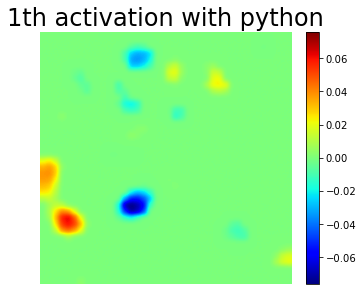

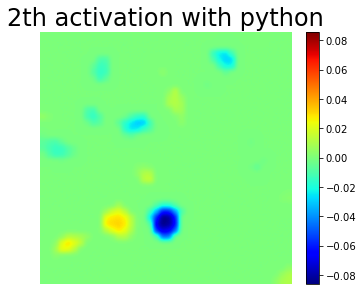

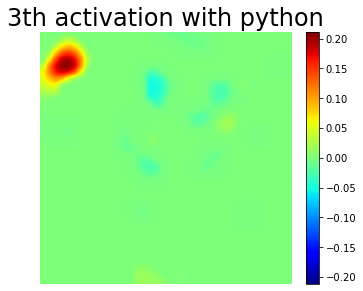

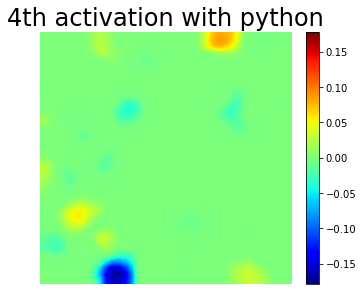

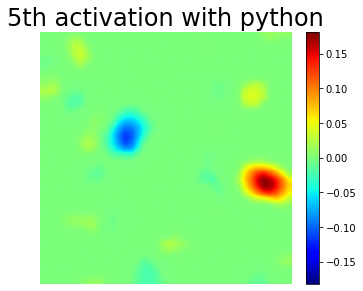

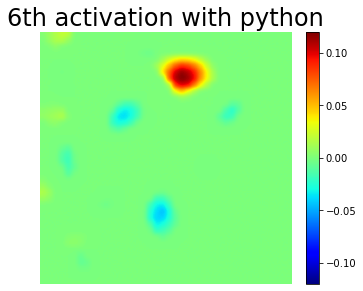

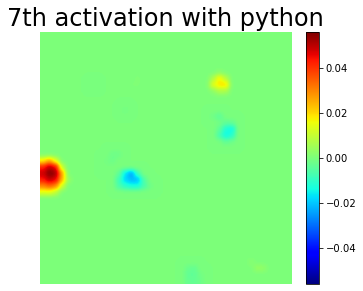

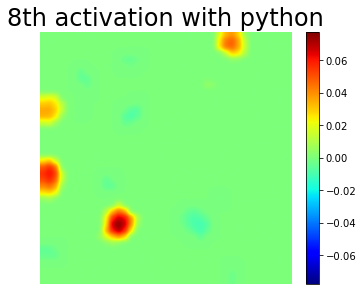

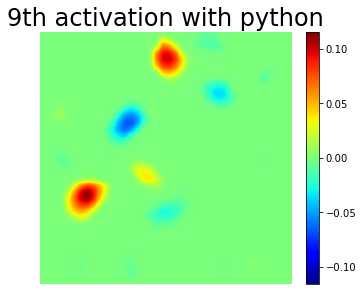

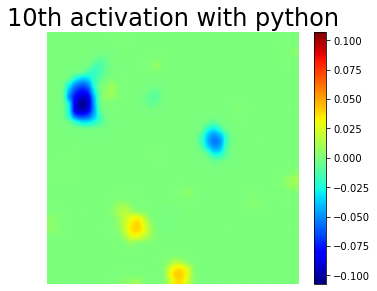

In [7]:
word_batch = cp.load('../../data/googleNgram/embed100.npy')
word_batch = cp.delete(word_batch, [55, 58, 84], axis = 1)
word_batch = word_batch[[0,1,2,3,4,5,6,7,8,9],:]
print(cp.shape(word_batch))

Phi = cp.load("../../data/codebook.npy")
print(cp.shape(Phi))

try:
    stimulus = perceive_to_get_stimulus(word_batch, Phi)
    activ = stimulate(stimulus)
    plot_word_activations(activ)
except RuntimeError as e:
    print(e)

### 2. PLot first 10 activations from C

In [12]:
neuron_shape = (40, 40)


def plot_word_activations(activity):
    for i in range(10):
        activ = activity[i]
        fig, ax = plt.subplots(figsize=(5, 5))
        l0norm = cp.abs(activ).max()
        im = ax.imshow(activ.reshape(neuron_shape[0], neuron_shape[1]),
                   cmap='jet', interpolation='gaussian', vmin=-l0norm, vmax=l0norm)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(im, cax=cax)
        ax.set_title(str(i + 1) + "th activation with C", fontsize=24)
        ax.set_axis_off()
        plt.savefig(str(i + 1) + "th activation with C")

(10, 1600)


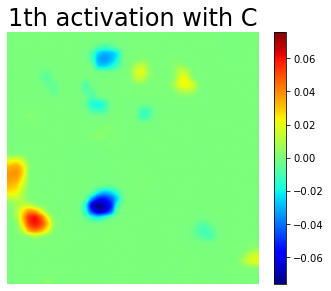

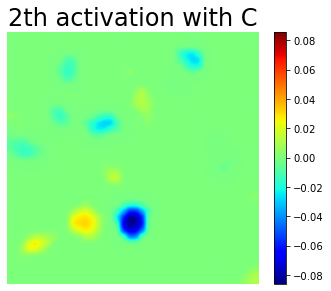

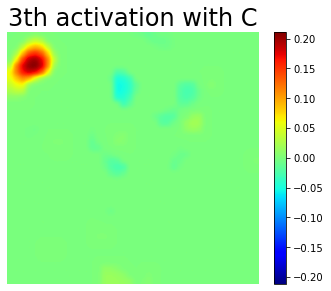

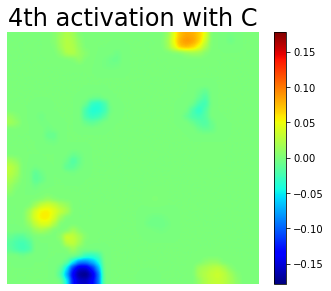

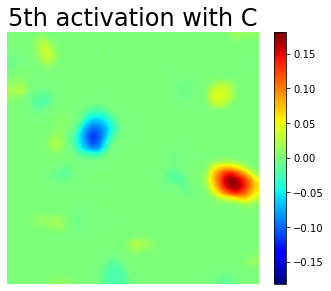

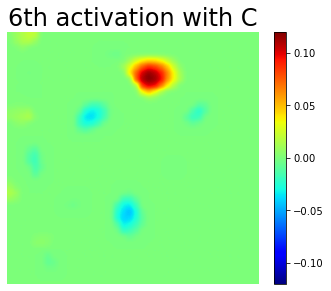

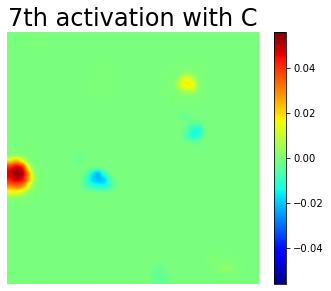

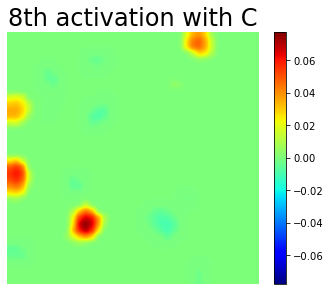

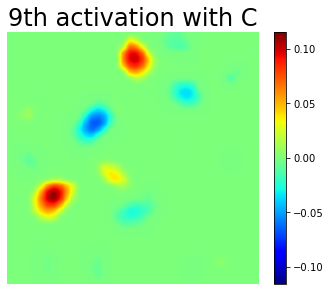

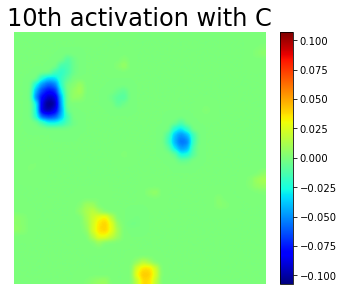

In [13]:
exc_act = cp.genfromtxt("exc_act.csv", delimiter=",")
print(exc_act.shape)
plot_word_activations(exc_act)